In [1]:
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from itertools import product, combinations

# N-Net with Adverserial Sub-Nets

We'll use MNIST as an example, but this should generalize

## Data Pre-Processing

In [2]:
(x_train, y_train), (x_test, y_test) = K.datasets.mnist.load_data()

In [3]:
IMAGE_SHAPE = x_train.shape[1:]

Scale from 255 grayscale to `[0,1]`

In [4]:
x_train, x_test  = x_train/255.0, x_test/255.0

Convert labels to one-hot representation

In [5]:
y_train_oh = K.utils.to_categorical(y_train, 10)

In [6]:
y_test_oh = K.utils.to_categorical(y_test, 10)

## Image Plotting Function

In [7]:
def plot_image(d, l):
    print("Label {}".format(l))
    plt.figure(figsize=(2,2))
    plt.imshow(d.reshape(IMAGE_SHAPE)*255, cmap='gray')

In [8]:
def printer(n, test=False):
    if test:
        plot_image(x_test[n], y_test[n])
    else:
        plot_image(x_train[n], y_train[n])
    plt.show()

Label 4


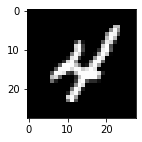

In [9]:
printer(9)

## Network Structure

Input Layers are Standard, a batch input and flatten the 2d images

In [10]:
def get_layer(module_size, n):
#     return (K.layers.Dense(module_size, name='Mod_'+str(n)+'r', activation='relu'), 
#             K.layers.Dense(module_size, name='Mod_'+str(n)+'s', activation='sigmoid'))
    return K.layers.Dense(module_size, name='Mod_'+str(n)+'s', activation='sigmoid')

In [11]:
def build_model(in_shape, module_size, n_modules, adv_weight=0.5):
    in_layer = K.layers.Input(shape=in_shape, name='image_input')
    flatten = K.layers.Flatten(name='image_flatten')(in_layer)
    modules = [get_layer(module_size, i) for i in range(n_modules)]
    #mod_out = [i[1](i[0](flatten)) for i in modules]
    mod_out = [i(flatten) for i in modules]
    concat = K.layers.Concatenate(name='concatenate')(mod_out)
    output = K.layers.Dense(10, name='output', activation='softmax')(concat)
    
    out_diff = [K.layers.Dot(1)([mod_out[i], mod_out[j]]) for i, j in combinations(range(n_modules), 2)]
    dot_avg = K.layers.Average(name='avg_adver')(out_diff)
    
    ret = K.Model(inputs=in_layer, outputs=[output, dot_avg])
    
    ret.compile(loss = {'output': 'categorical_crossentropy', 'avg_adver': 'mae'},
                loss_weights = {'output': 1.0, 'avg_adver': adv_weight},
                optimizer='RMSProp',
                metrics={'output': 'categorical_crossentropy'})
    
    return ret, modules

In [12]:
model, mods = build_model(IMAGE_SHAPE, 5, 3)

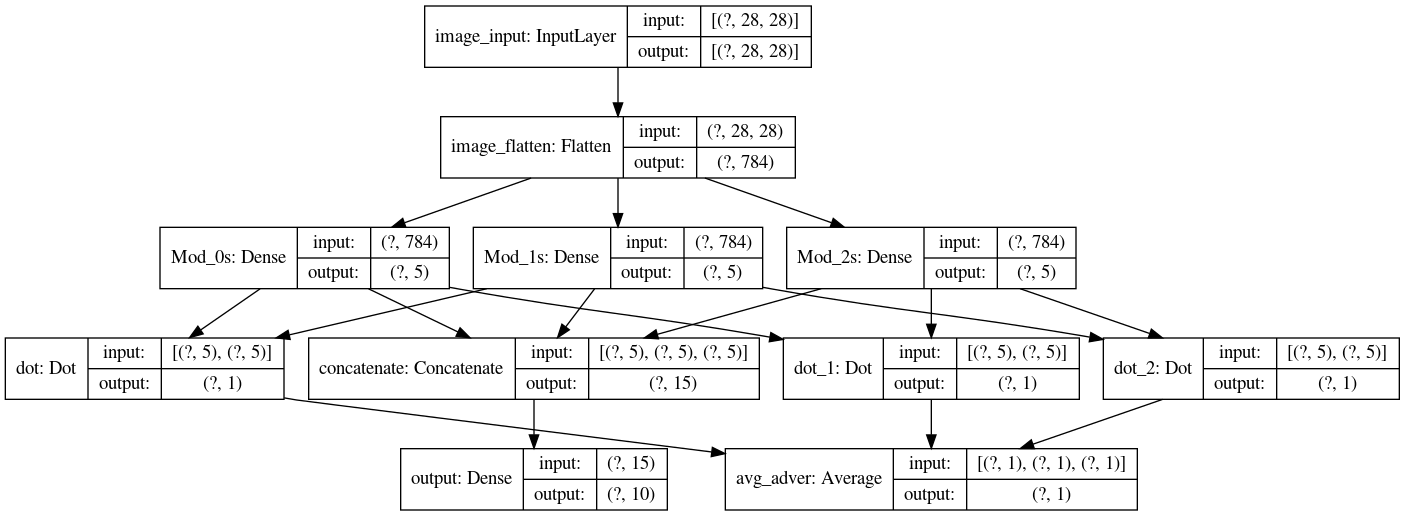

In [13]:
K.utils.plot_model(model, show_shapes=True)

In [14]:
hist = model.fit(x_train, 
                 {'output': y_train_oh, 'avg_adver': np.ones((y_train.shape[0], 1))},
                 batch_size=100,
                 epochs=10,
                 #validation_data= (x_test, {'classification': y_test, 'autoencoder': x_test}),
                 verbose=1)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/sample - loss: 1.3365 - output_loss: 1.2967 - avg_adver_loss: 0.0796 - output_categorical_crossentropy: 1.2967
Epoch 2/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.5910 - output_loss: 0.5406 - avg_adver_loss: 0.1008 - output_categorical_crossentropy: 0.5406
Epoch 3/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.4274 - output_loss: 0.3774 - avg_adver_loss: 0.1000 - output_categorical_crossentropy: 0.3774
Epoch 4/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.3695 - output_loss: 0.3210 - avg_adver_loss: 0.0970 - output_categorical_crossentropy: 0.3210
Epoch 5/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3391 - output_loss: 0.2922 - avg_adver_loss: 0.0938 - output_categorical_crossentropy: 0.2922
Epoch 6/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3189 - ou

In [15]:
res = model.predict(x_test)

In [16]:
p = np.argmax(res[0], axis=1)

In [17]:
np.sum(p == y_test)/float(y_test.shape[0])

0.9327

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
cm = confusion_matrix(y_test, p)

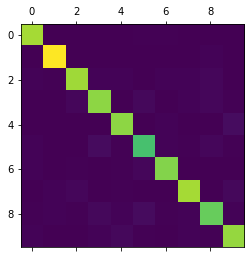

In [20]:
plt.matshow(cm);

In [25]:
def plot_weights(modules):
    W = np.stack([m.get_weights()[0] for m in modules])
    W = (W-W.min())/(W.max()-W.min())
    
    width = W.shape[-1]
    height = W.shape[0]

    f, a = plt.subplots(height, width, sharex=True, sharey=True, figsize=(width*3, height*3))
    f.subplots_adjust(wspace = 0.01, hspace = 0.01)
    
    for i in range(height):
        for j in range(width):
            a[i,j].matshow(W[i, :, j].reshape(IMAGE_SHAPE))
            a[i,j].axis('off')        

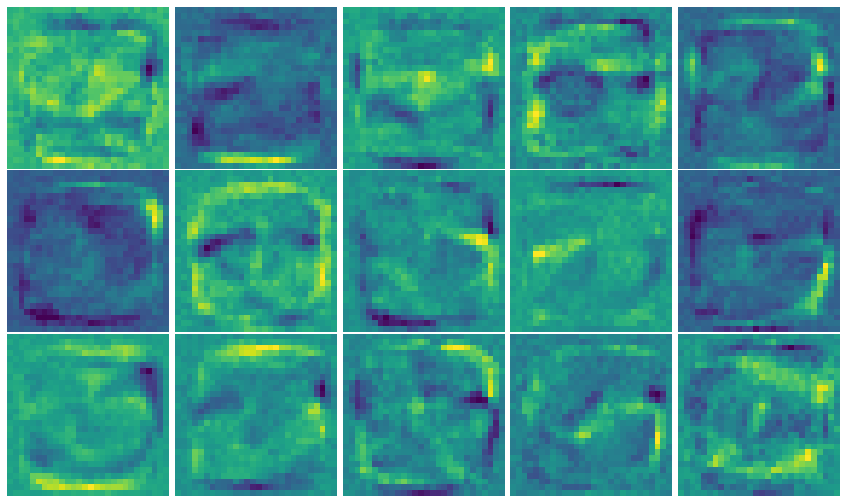

In [26]:
plot_weights(mods)

## Compare Adverserial Strength

In [27]:
def full_test(adv_wt, epochs=100, batch_size=100):
    model, mods = build_model(IMAGE_SHAPE, 5, 4, adv_weight=adv_wt)
    hist = model.fit(x_train, 
                 {'output': y_train_oh, 'avg_adver': np.ones((y_train.shape[0], 1))},
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=0)
    res = model.predict(x_test)
    p = np.argmax(res[0], axis=1)
    print('Acc: {}'.format(np.sum(p == y_test)/float(y_test.shape[0])))
    plot_weights(mods)

Acc: 0.9564


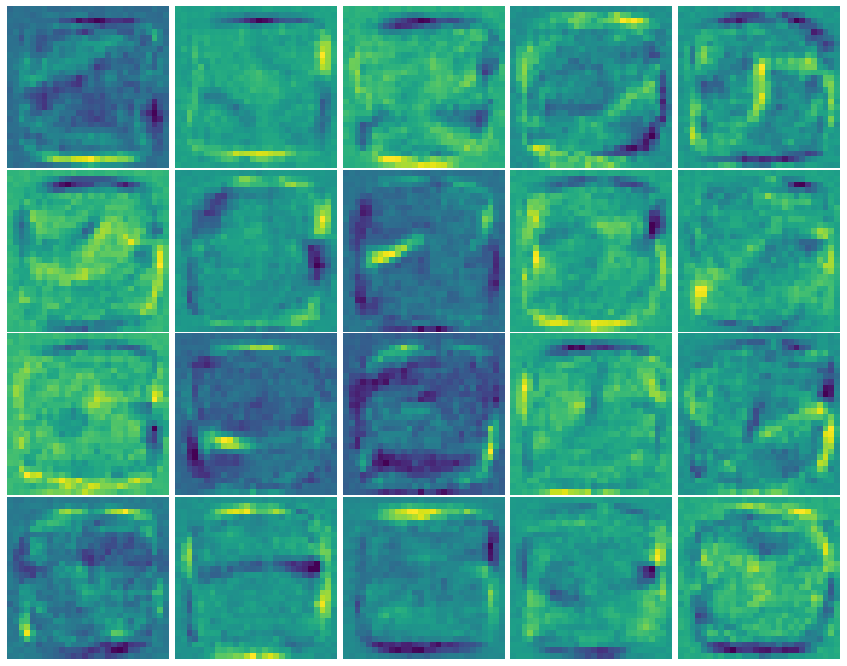

In [28]:
full_test(0.0, epochs=25)

Acc: 0.9536


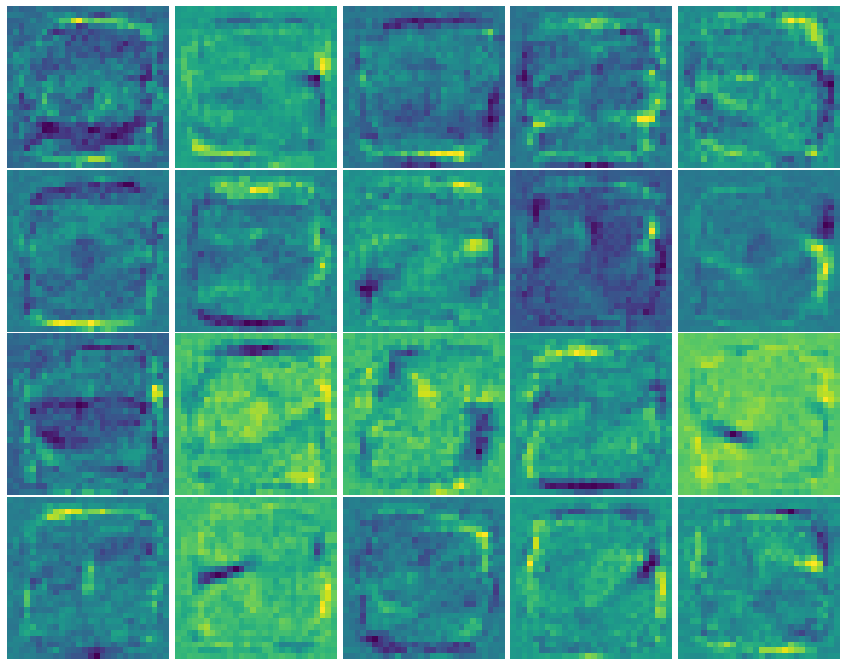

In [29]:
full_test(0.5, epochs=25)

Acc: 0.9437


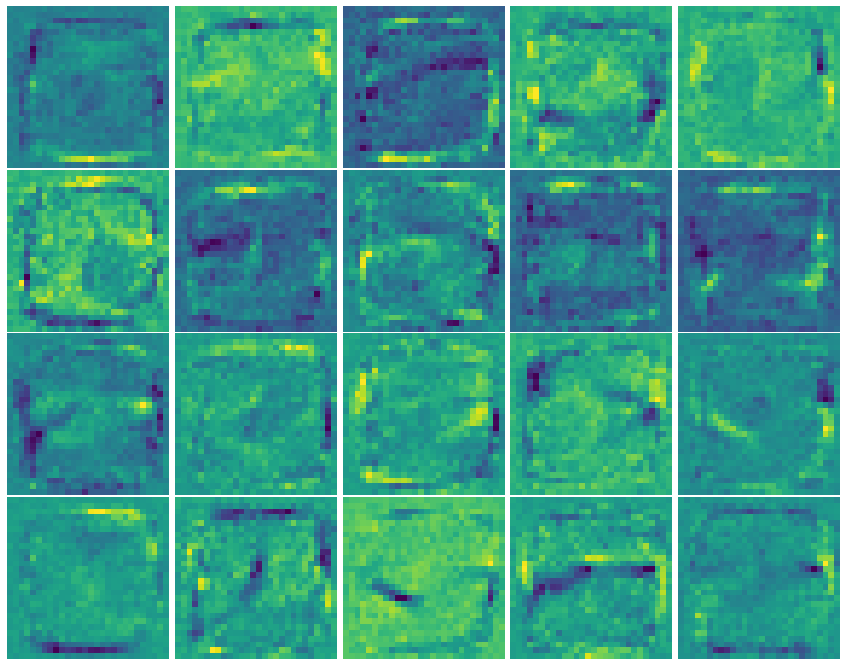

In [30]:
full_test(1.0, epochs=25)

Acc: 0.9441


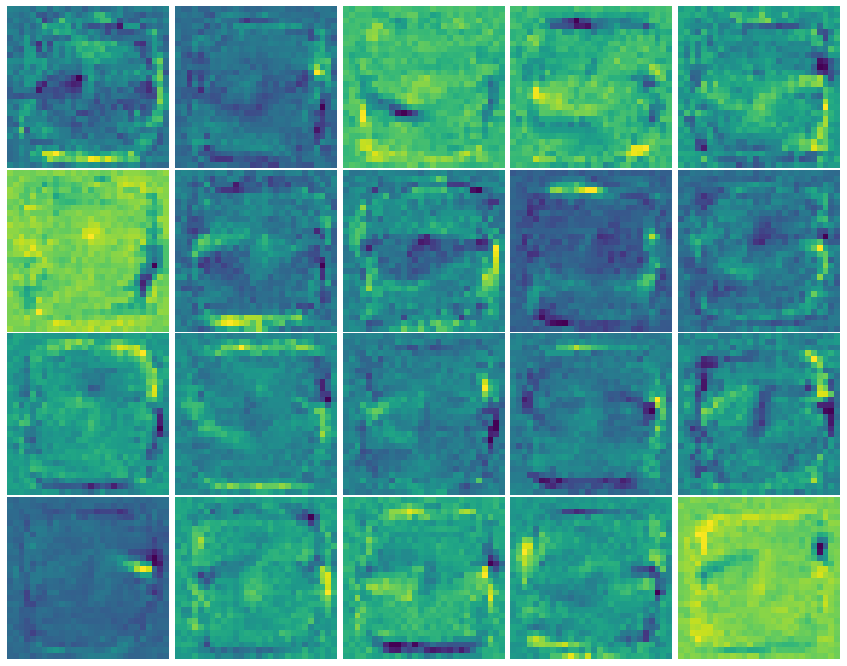

In [31]:
full_test(2.0, epochs=25)

Acc: 0.9406


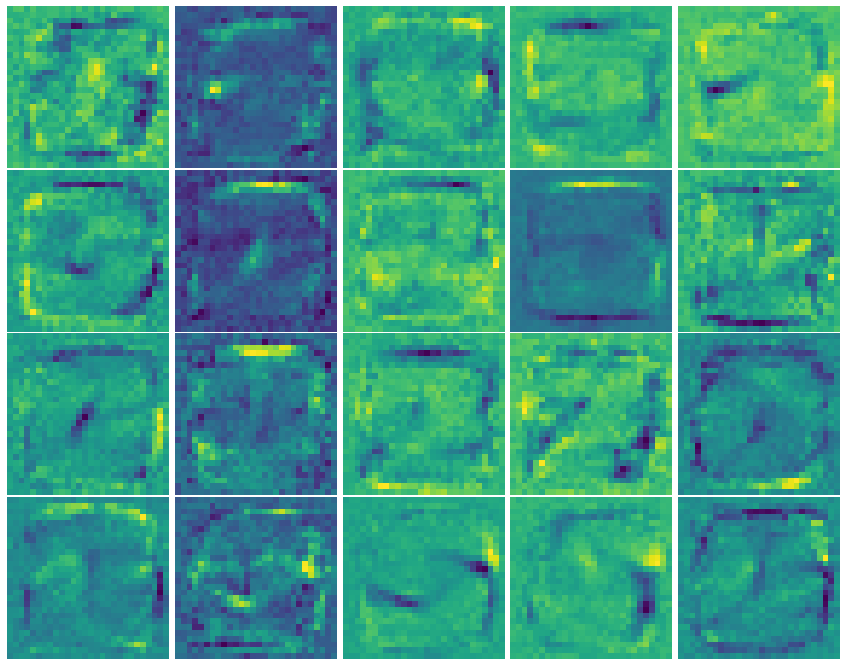

In [32]:
full_test(10.0, epochs=25)

Acc: 0.9318


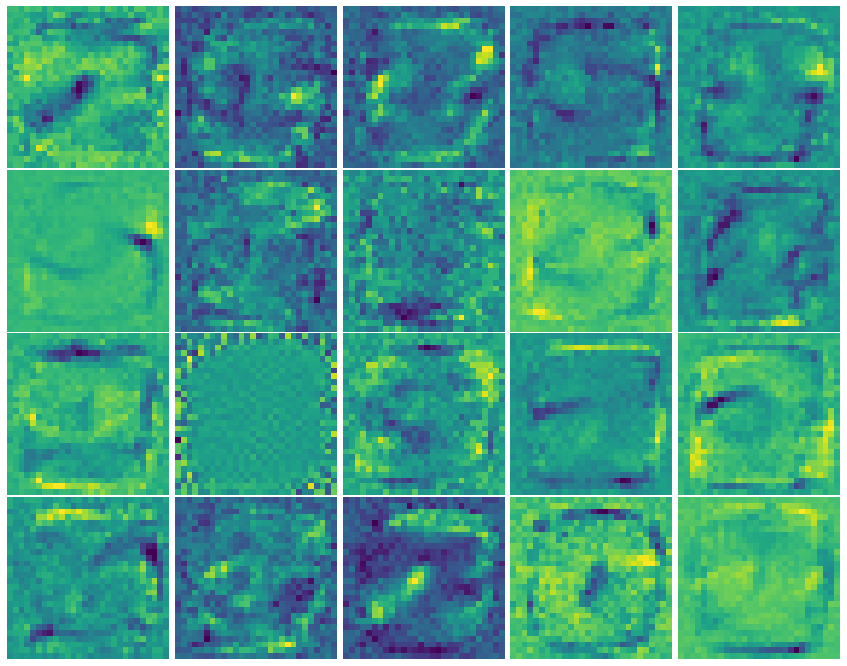

In [33]:
full_test(30.0, epochs=25)

Acc: 0.7285


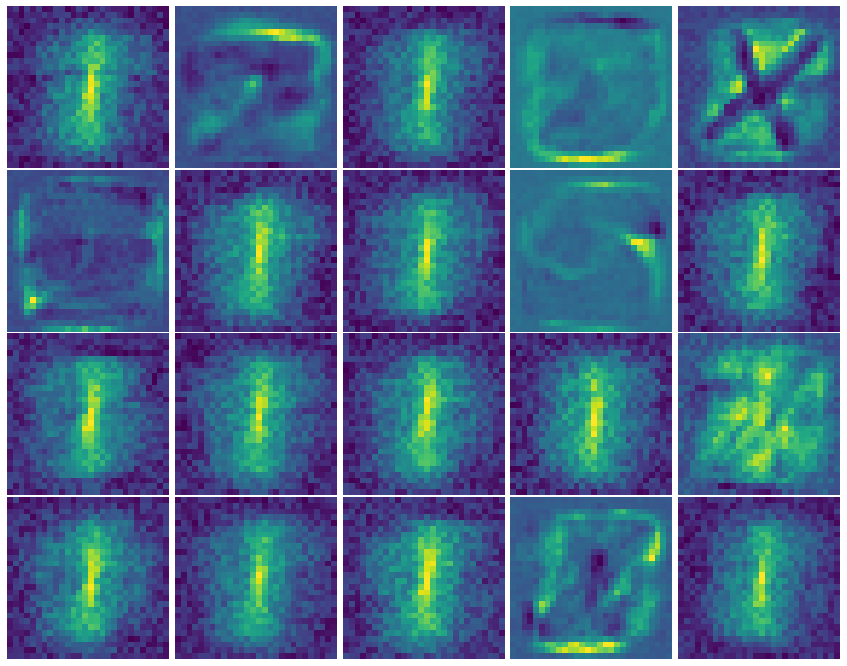

In [34]:
full_test(-0.5, epochs=25)